# ACP : Exemple simple

## Pré-étude des données

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)

Ecart type : 3.4729999129083966
Moyenne : 10.222222222222221
Variance : 12.06172839506173


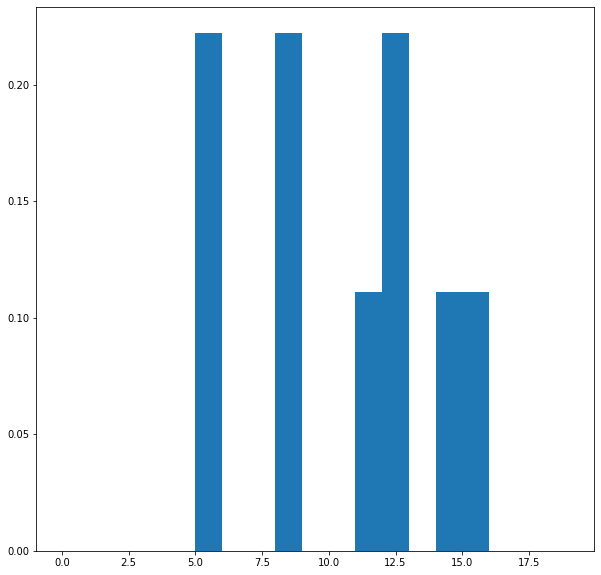

In [3]:
import pandas as pd

X = pd.read_csv("notes.csv",sep=";",decimal=".",header=0,index_col = 0)
X = np.transpose(X)

nomi = list(X.index)
nomv = list(X.columns)

FRAN_VALUES = X.loc[:,['fran']].values 


plt.hist(FRAN_VALUES, bins=range(20), density=True)
print('Ecart type : ' + str(np.std(FRAN_VALUES)))
print('Moyenne : ' + str(np.mean(FRAN_VALUES)))
print('Variance : ' + str(np.var(FRAN_VALUES)))

Ecart type : 2.813108644704925
Moyenne : 10.055555555555555
Variance : 7.913580246913581


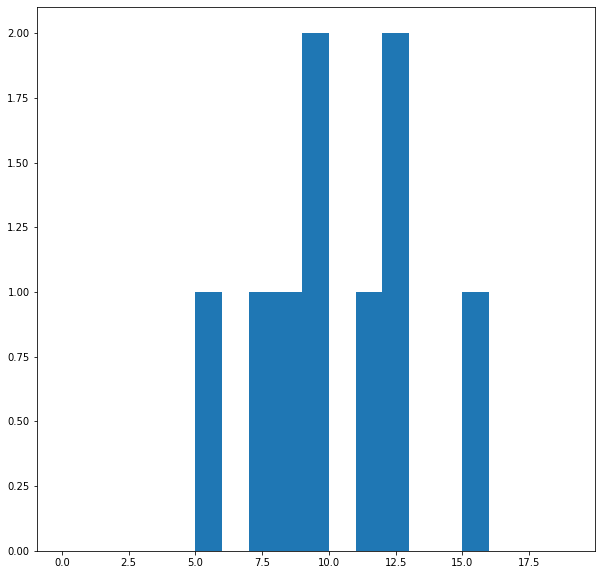

In [4]:
LATI_VALUES = X.loc[:,['lati']].values 
plt.hist(LATI_VALUES, bins=range(20))
print('Ecart type : ' + str(np.std(LATI_VALUES)))
print('Moyenne : ' + str(np.mean(LATI_VALUES)))
print('Variance : ' + str(np.var(LATI_VALUES)))

Ecart type : 3.1896098681674396
Moyenne : 9.75
Variance : 10.17361111111111


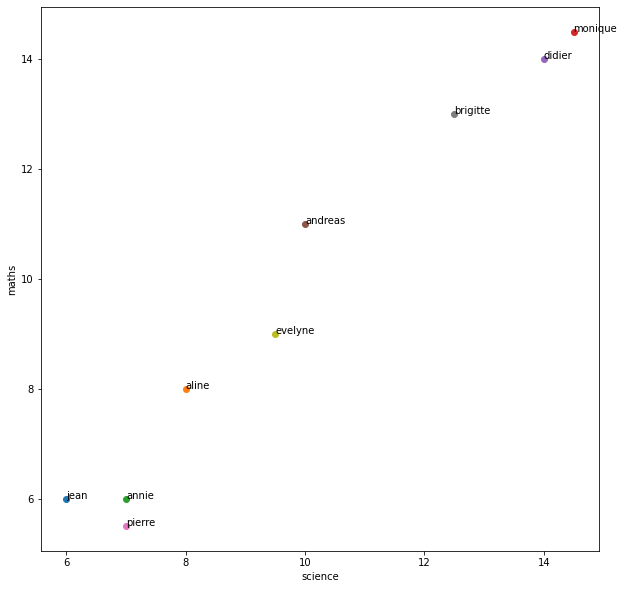

In [5]:
data = X.loc[:, ['scie', 'math']].values
plt.xlabel('science')
plt.ylabel('maths')
for i in range(len(nomi)):
    plt.scatter(data[i, 0], data[i, 1])
    plt.text(data[i, 0], data[i, 1], nomi[i])
    
print('Ecart type : ' + str(np.std(data)))
print('Moyenne : ' + str(np.mean(data)))
print('Variance : ' + str(np.var(data)))

## Calcul de l'ACP

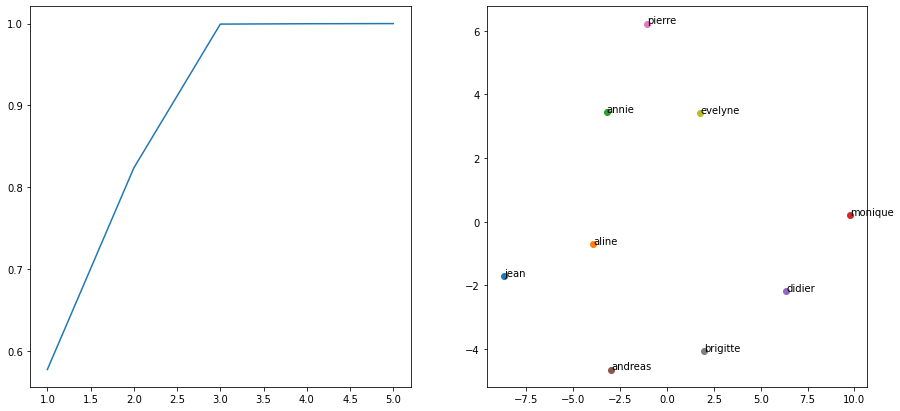

In [6]:
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = (15, 7)

acp = PCA(n_components=len(nomv))
cc = acp.fit_transform(X)


plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(nomv) + 1), np.cumsum(acp.explained_variance_ratio_))

plt.subplot(1, 2, 2)
for i in range(len(nomi)):
    plt.scatter(cc[i, 0], cc[i, 1]) # en changeant les indices, on change les plans factoriels
    plt.text(cc[i, 0], cc[i, 1], nomi[i])


## Représentation
$$Corr(\Epsilon_k, Y_j)= acp.components[j,k] \times \sqrt{\frac{\lambda_j}{\sigma_k^2}} \\ k=1,...,p \ et \ j=1,...,p$$

In [7]:
import math

def compute_corr(iv, pca):
    p = len(pca.components_)
    corr = np.zeros((p, p))
    for k in range(p):
        for j in range(p):
            corr[k, j] = (
                pca.components_[j, k] * 
                math.sqrt(pca.explained_variance_[j] / np.var(iv[:, k], ddof=1))
            )
    
    return corr

In [8]:
cor_matrix = compute_corr(X.values, acp)
print(nomv)
print(cor_matrix)

['math', 'scie', 'fran', 'lati', 'd-m ']
[[ 8.10417374e-01 -5.83770349e-01  4.46393796e-02 -1.26133592e-02
  -1.68549005e-02]
 [ 9.01064025e-01 -4.32215058e-01  1.41848973e-02  2.72611682e-02
   1.81489210e-02]
 [ 7.53542348e-01  6.50703801e-01 -9.13332717e-02  1.67128806e-02
  -1.17220157e-02]
 [ 9.15706957e-01  3.99277843e-01 -2.35221609e-02 -3.53305941e-02
   1.60134233e-02]
 [ 5.52998116e-02  1.33254172e-01  9.89536306e-01  1.72443095e-03
  -4.27513450e-04]]


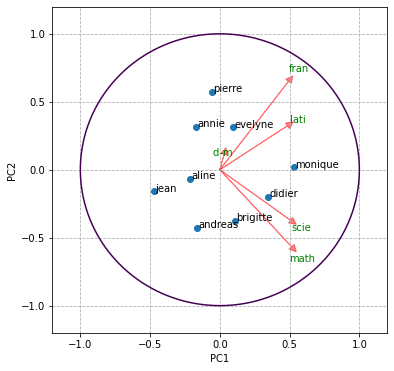

In [9]:
from affichage_acp import my_biplot

my_biplot(
    score = cc[:,0:2],
    coeff = np.transpose(acp.components_[0:2,:]),
    coeff_labels = nomv, 
    score_labels = nomi,
    nomx = "PC1",
    nomy = "PC2"
    )

# Données réelles

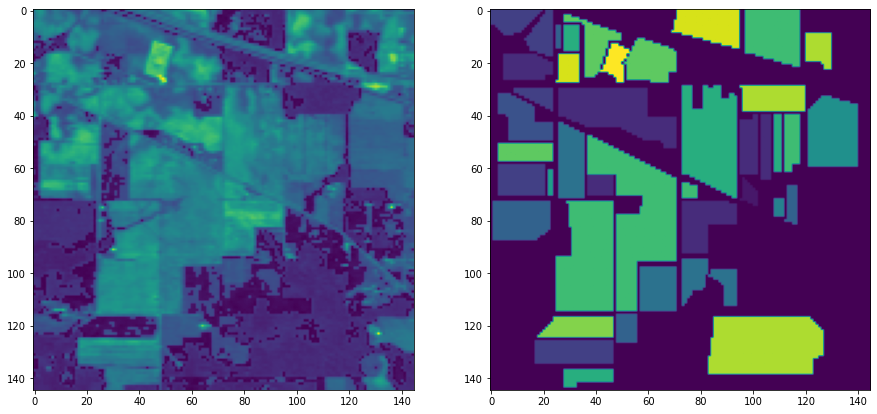

In [10]:
from scipy.io import loadmat

imgtmp = loadmat("Indian_pines_corrected.mat")
img = np.float32(imgtmp['indian_pines_corrected'])

maptmp = loadmat("Indian_pines_gt.mat")
map = maptmp['indian_pines_gt']

res = img[:,:,18]


plt.subplot(1, 2, 1)
plt.imshow((res - np.min(res)) / (np.max(res) - np.min(res)))

plt.subplot(1, 2, 2)
plt.imshow(map)

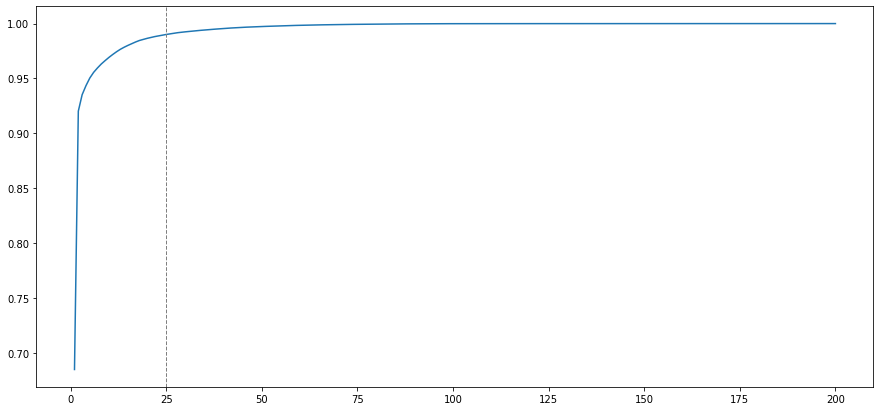

In [11]:
mat = np.reshape(img, ((len(img) * len(img[0])), 200))

acp = PCA(n_components=200)
cc = acp.fit_transform(mat)

plt.plot(np.arange(1, 200 + 1), np.cumsum(acp.explained_variance_ratio_))
plt.axvline(x=25, c='grey', lw=1, linestyle='dashed')


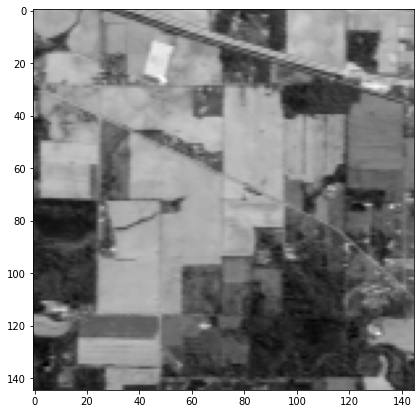

In [12]:
cc2 = cc[:,0]
cc2 = np.reshape(cc2, (145, 145))
plt.imshow(cc2, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


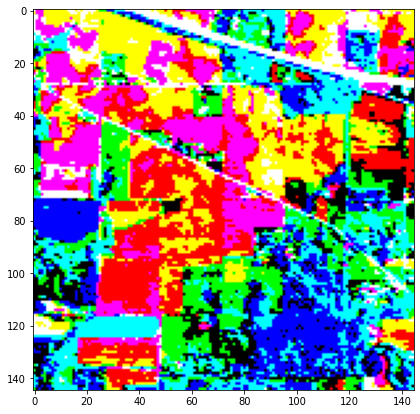

In [13]:
cc_r = cc[:, 0]
cc_g = cc[:, 1]
cc_b = cc[:, 2]

cc_r = np.reshape(cc_r, (145, 145))
cc_g = np.reshape(cc_g, (145, 145))
cc_b = np.reshape(cc_b, (145, 145))

cc_colored = np.stack((cc_r, cc_g, cc_b), axis=2)

plt.imshow(cc_colored)

In [14]:
corr = compute_corr(mat, acp)
print(corr.shape)


(200, 200)


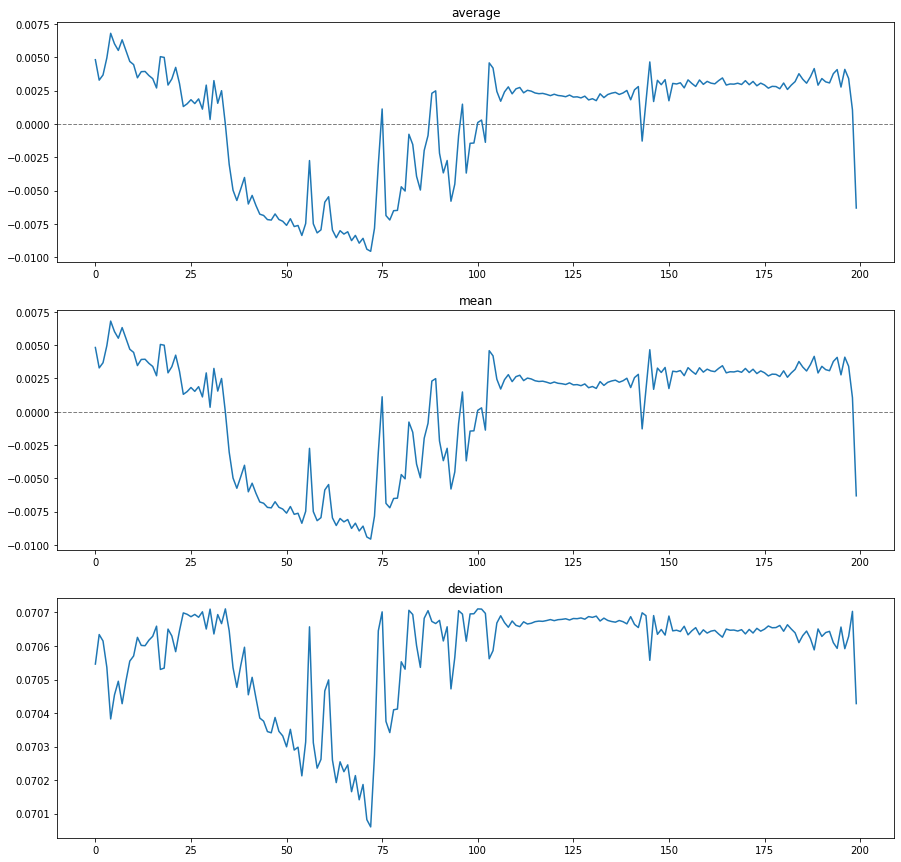

In [15]:
avg = []
mean = []
std_dev = []


for corr_line in corr:
    avg.append(np.average(corr_line))
    std_dev.append(np.std(corr_line))
    mean.append(np.mean(corr_line))

plt.rcParams['figure.figsize'] = (15, 15)


fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.axhline(y=0, c='grey', lw=1, linestyle='dashed')
ax1.set_title('average')
ax1.plot(avg)

ax2.axhline(y=0, c='grey', lw=1, linestyle='dashed')
ax2.set_title('mean')
ax2.plot(mean)

ax3.set_title('deviation')
ax3.plot(std_dev)

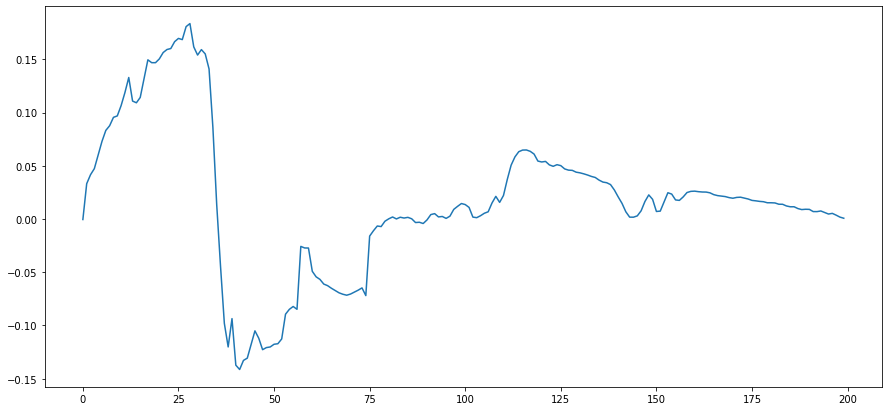

In [16]:
plt.rcParams['figure.figsize'] = (15, 7)

# signature spectrale de l'axe 0
plt.plot(acp.components_[0,:])

# ACP

In [17]:
def my_acp(data):
    n, p = data.shape

    c = np.array((n, p))
    lamb = np.array(p)
    u = np.array((p, p))

    # matrice de variance-covariance
    cov = np.cov(data)

    print(evalues, evectors)
    return c, lamb, u



In [18]:

cov = np.cov(mat)
print(cov.shape)



[[2012175.20399497 2240912.35869347 2309984.699799   ... 2205317.48497488
  2088850.56909548 2115753.74311558]
 [2240912.35869347 2518196.29909548 2592211.99015075 ... 2460171.41728643
  2327951.14070352 2357169.19356784]
 [2309984.699799   2592211.99015075 2677713.46773869 ... 2534985.82452261
  2399217.11557789 2430241.41226131]
 ...
 [2205317.48497488 2460171.41728643 2534985.82452261 ... 3206633.06321608
  2999537.23869347 3039814.15095477]
 [2088850.56909548 2327951.14070352 2399217.11557789 ... 2999537.23869347
  2818704.99246231 2852151.65326633]
 [2115753.74311558 2357169.19356784 2430241.41226131 ... 3039814.15095477
  2852151.65326633 2891576.53025126]]
